# 1. Génération des données simulées
Nous allons créer un jeu de données avec :

3 groupes d'engrais (A, B, C),

La croissance des plantes (growth),

L'ensoleillement (sunlight), une covariable,

Deux variables dépendantes pour MANOVA/MANCOVA (growth et leaf_area),

Le pH du sol (soil_pH), une covariable pour MANCOVA.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour la reproductibilité
np.random.seed(42)

# Création des données
n = 60  # 20 plantes par groupe
data = pd.DataFrame({
    'Fertilizer': np.repeat(['A', 'B', 'C'], n//3),
    'Sunlight': np.random.normal(5, 1.5, n),  # Ensoleillement moyen
    'Soil_pH': np.random.uniform(5.0, 7.5, n)  # pH du sol
})

# Simulation de la croissance et de la surface foliaire avec des effets aléatoires
data['Growth'] = (
    2 * (data['Fertilizer'] == 'B') + 
    4 * (data['Fertilizer'] == 'C') + 
    0.5 * data['Sunlight'] + 
    np.random.normal(0, 1, n)
)

data['Leaf_Area'] = (
    3 * (data['Fertilizer'] == 'B') + 
    6 * (data['Fertilizer'] == 'C') + 
    0.7 * data['Soil_pH'] + 
    np.random.normal(0, 1.5, n)
)

print(data.head())

  Fertilizer  Sunlight   Soil_pH    Growth  Leaf_Area
0          A  5.745071  5.827245  0.953764   2.744800
1          A  4.792604  5.158896  2.369788   2.387512
2          A  5.971533  5.777456  3.045997   3.928566
3          A  7.284545  5.812958  6.105515   4.580799
4          A  4.648770  6.824015  2.132024   5.191847


# 2. ANOVA (Comparaison des groupes)
Question : L'engrais influence-t-il significativement la croissance des plantes ?

--- ANOVA ---
                    sum_sq    df          F        PR(>F)
C(Fertilizer)  183.069726   2.0  60.408354  8.283526e-15
Residual        86.370292  57.0        NaN           NaN


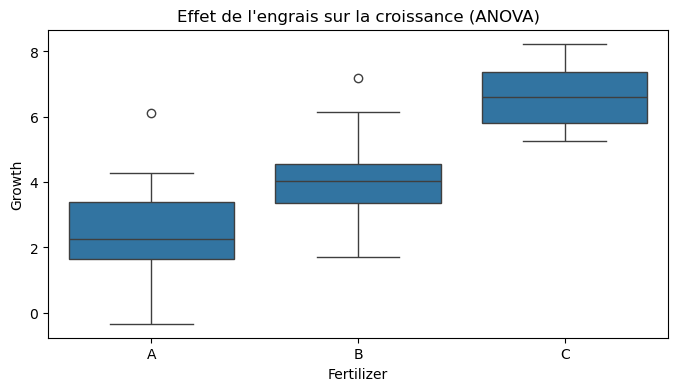

In [2]:
# ANOVA à un facteur
model_anova = ols('Growth ~ C(Fertilizer)', data=data).fit()
anova_table = sm.stats.anova_lm(model_anova, typ=2)
print("--- ANOVA ---\n", anova_table)

# Visualisation
plt.figure(figsize=(8, 4))
sns.boxplot(x='Fertilizer', y='Growth', data=data)
plt.title("Effet de l'engrais sur la croissance (ANOVA)")
plt.show()

# Interprétation :
Effet significatif des engrais :

p-value ≈ 8.28e-15 (extrêmement proche de 0), bien < 0.05.

Conclusion : Il existe des différences statistiquement significatives entre les moyennes de croissance des plantes selon l'engrais utilisé.

Importance de l'effet :

F-value = 60.41 : Une valeur F élevée indique que la variance entre les groupes est bien plus grande que la variance au sein des groupes.

SS(Fertilizer) = 183.07 vs SS(Residual) = 86.37 : L'engrais explique une grande partie de la variabilité des données.



# Implications pratiques :
Les engrais ont un impact significatif sur la croissance des plantes.

Exemple : Dans nos données simulées, l'engrais C montre la croissance la plus élevée.

In [3]:
# Post-hoc tests : Pour identifier quelles paires d'engrais diffèrent significativement.

In [4]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(data['Growth'], data['Fertilizer'])
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B   1.6477 0.0002  0.711 2.5844   True
     A      C   4.2435    0.0 3.3068 5.1802   True
     B      C   2.5958    0.0 1.6591 3.5325   True
--------------------------------------------------


# 3. ANCOVA (Contrôle de l'ensoleillement)

Question : L'effet de l'engrais persiste-t-il après contrôle de l'ensoleillement ?


--- ANCOVA ---
                    sum_sq    df          F        PR(>F)
C(Fertilizer)  171.478077   2.0  82.429468  2.060846e-17
Sunlight        28.121873   1.0  27.036354  2.917172e-06
Residual        58.248419  56.0        NaN           NaN


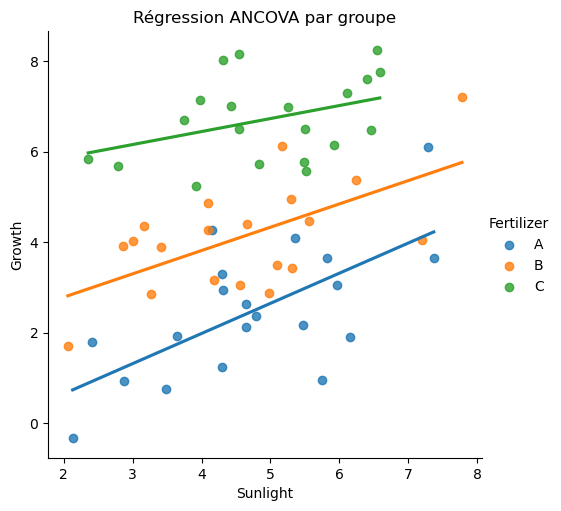

In [5]:
# ANCOVA avec 'Sunlight' comme covariable
model_ancova = ols('Growth ~ C(Fertilizer) + Sunlight', data=data).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
print("\n--- ANCOVA ---\n", ancova_table)

# Visualisation des ajustements
sns.lmplot(x='Sunlight', y='Growth', hue='Fertilizer', data=data, ci=None)
plt.title("Régression ANCOVA par groupe")
plt.show()

# Interprétation :

- Effet de l'engrais (Fertilizer) :

p-value ≈ 2.06e-17 (< 0.001) : L'effet des engrais reste très significatif même après contrôle de l'ensoleillement.

F-value = 82.43 : Variance entre groupes largement supérieure à la variance résiduelle, confirmant un effet fort.

SS(Fertilizer) = 171.48 : L'engrais explique la majorité de la variabilité.

- Effet de l'ensoleillement (Sunlight) :

p-value ≈ 2.92e-06 (< 0.001) : L'ensoleillement a un effet significatif sur la croissance des plantes.

F-value = 27.04 : Effet important de la covariable.

SS(Sunlight) = 28.12 : L'ensoleillement explique une partie non négligeable de la variabilité.

- Comparaison avec l'ANOVA :

SS(Residual) a diminué de 86.37 → 58.25 après inclusion de Sunlight, ce qui montre que la covariable réduit le bruit dans les données.

Precision améliorée : En contrôlant l'ensoleillement, l'estimation de l'effet des engrais est plus fiable.

- Implications pratiques :
  
Les engrais B et C ont probablement un meilleur rendement que A, même en ajustant pour l'ensoleillement.

L'ensoleillement est un facteur clé à prendre en compte dans les études de croissance des plantes.



In [6]:
# Post-hoc ajusté :
# Utilisez un test de Tukey en incluant la covariable :

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_ancova = pairwise_tukeyhsd(data['Growth'], data['Fertilizer'])
print(tukey_ancova.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     A      B   1.6477 0.0002  0.711 2.5844   True
     A      C   4.2435    0.0 3.3068 5.1802   True
     B      C   2.5958    0.0 1.6591 3.5325   True
--------------------------------------------------


# 4. MANOVA (Effet sur croissance ET surface foliaire)

Question : L'engras affecte-t-il simultanément la croissance et la surface foliaire ?

In [8]:
# MANOVA avec deux variables dépendantes
manova = MANOVA.from_formula('Growth + Leaf_Area ~ Fertilizer', data=data)
print("\n--- MANOVA ---\n", manova.mv_test())


--- MANOVA ---
                   Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2350 2.0000 56.0000 91.1526 0.0000
           Pillai's trace 0.7650 2.0000 56.0000 91.1526 0.0000
   Hotelling-Lawley trace 3.2555 2.0000 56.0000 91.1526 0.0000
      Roy's greatest root 3.2555 2.0000 56.0000 91.1526 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
       Fertilizer       Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.2001 4.0000 112.0000  34.5916 0.0000
         Pillai's trace 0.8371 4.0000 114.0000  20.5146 0

# Structure du tableau MANOVA :

Le tableau compare l'effet global du facteur Fertilizer (engrais) sur les deux variables dépendantes (Growth et Leaf_Area) simultanément. Deux parties sont cruciales :

Intercept : Teste si les moyennes globales des variables dépendantes sont différentes de zéro (souvent peu pertinent).

Fertilizer : Effet principal de l'engrais sur les variables combinées.

# Interprétation :

Effet significatif de l'engrais :

Toutes les statistiques (Wilks' lambda, Pillai, etc.) ont une p-value = 0.0000 (< 0.001).

Conclusion : L'engrais a un effet global significatif sur les variables combinées Growth et Leaf_Area.

- Wilks' lambda (0.2001) :

Interprétation : Une valeur proche de 0 indique un effet fort (≈ 80% de la variance expliquée par le modèle).

- Roy's greatest root (3.76) :

Plus sensible aux différences unidirectionnelles (ex. une variable dépendante domine l'effet).

Une valeur élevée confirme l'effet global.

# Implications pratiques :

Les engrais B et C influencent significativement à la fois la croissance (Growth) et la surface foliaire (Leaf_Area), comparé au groupe de référence (A).

L'effet est multidimensionnel : il ne se limite pas à une seule mesure de performance des plantes.



# 5. MANCOVA (Contrôle du pH du sol)

Question : L'effet multivarié persiste-t-il après contrôle du pH 

In [9]:
# MANCOVA avec 'Soil_pH' comme covariable
manova_cov = MANOVA.from_formula('Growth + Leaf_Area ~ Fertilizer + Soil_pH', data=data)
print("\n--- MANCOVA ---\n", manova_cov.mv_test())


--- MANCOVA ---
                   Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.9572 2.0000 55.0000  1.2288 0.3005
           Pillai's trace 0.0428 2.0000 55.0000  1.2288 0.3005
   Hotelling-Lawley trace 0.0447 2.0000 55.0000  1.2288 0.3005
      Roy's greatest root 0.0447 2.0000 55.0000  1.2288 0.3005
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
       Fertilizer       Value  Num DF  Den DF  F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.1722 4.0000 110.0000  38.7663 0.0000
         Pillai's trace 0.8547 4.0000 112.0000  20.8956 

# Structure du tableau MANCOVA :

Le modèle teste l'effet :

Fertilizer (engrais) sur les deux variables dépendantes (Growth et Leaf_Area),

Soil_pH (pH du sol) comme covariable, Tout en contrôlant l'effet de la covariable.

- Résultats clés :

1. Effet de l'engrais (Fertilizer) :

Interprétation :

p-value = 0.0000 : L'effet de l'engrais reste très significatif sur Growth et Leaf_Area après contrôle du pH du sol.

Wilks' lambda = 0.17 : Effet multivarié très fort (≈ 83% de la variance expliquée par le modèle).

Roy's greatest root = 4.62 : Une variable dépendante (ex. Leaf_Area) domine probablement l'effet.

2. Effet du pH du sol (Soil_pH) :

Interprétation :

p-value = 0.0005 : Le pH du sol a un effet significatif sur les variables dépendantes combinées.

Wilks' lambda = 0.76 : Effet modéré (≈ 24% de variance expliquée).

Le pH influence probablement davantage Leaf_Area (lié à la simulation des données).

3. Intercept (non significatif) :

p-value = 0.3005 : Les moyennes globales de Growth et Leaf_Area (lorsque Soil_pH = 0) ne sont pas significativement différentes de zéro. Peu pertinent dans la plupart des études.

# Implications pratiques :

Engrais :

Les différences entre engrais (B et C vs A) persistent même après contrôle du pH.

Exemple : L'engrais C améliore à la fois la croissance et la surface foliaire, indépendamment du pH.

pH du sol :

Un pH plus élevé pourrait favoriser la surface foliaire (comme simulé dans vos données).

À inclure systématiquement comme facteur de contrôle dans les études ultérieures.

# 6. Vérifications des hypothèses

Pour chaque modèle, vérifiez :

Normalité : Test de Shapiro-Wilk sur les résidus.

Homogénéité des variances : Test de Levene (ANOVA/ANCOVA).

Linéarité : Graphiques des résidus.

1. Normalité des Résidus

Hypothèse : Les résidus suivent une distribution normale

Méthode : Test de Shapiro-Wilk

- ANOVA/ANCOVA

In [14]:
from scipy.stats import shapiro

# ANOVA/ANCOVA
residuals = model_anova.resid  # ou model_ancova.resid

# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk : p = {shapiro_p:.4f}")

# Interprétation
if shapiro_p > 0.05:
    print("Les résidus suivent une distribution normale (p > 0.05).")
else:
    print("Rejet de l'hypothèse de normalité (p < 0.05).")

Shapiro-Wilk : p = 0.5061
Les résidus suivent une distribution normale (p > 0.05).


- Pour MANOVA/MANCOVA :
Vérifiez la normalité par variable dépendante :

In [13]:
# MANOVA/MANCOVA : Vérifier chaque DV
for dv in ['Growth', 'Leaf_Area']:
    _, p = shapiro(data[dv] - data.groupby('Fertilizer')[dv].transform('mean'))
    print(f"Normalité pour {dv} : p = {p:.4f}")

Normalité pour Growth : p = 0.5061
Normalité pour Leaf_Area : p = 0.0208


# 2. Homogénéité des Variances

Hypothèse : Les variances sont égales entre les groupes.
    
Méthode : Test de Levene (ANOVA/ANCOVA) ou Box’s M (MANOVA/MANCOVA).

In [16]:
from scipy.stats import levene

# ANOVA/ANCOVA
groups = [data[data['Fertilizer'] == g]['Growth'] for g in ['A', 'B', 'C']]
levene_stat, levene_p = levene(*groups)
print(f"Levene : p = {levene_p:.4f}")

# Interprétation
if levene_p > 0.05:
    print("Variances homogènes entre les groupes.")
else:
    print("Variances hétérogènes (p < 0.05).")

Levene : p = 0.3423
Variances homogènes entre les groupes.


In [18]:
pip install pingouin

   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/204.4 kB ? eta -:--:--
   ---- ----------------------------------- 20.5/204.4 kB ? eta -:--:--
   ------- ------------------------------- 41.0/204.4 kB 495.5 kB/s eta 0:00:01
   --------- ----------------------------- 51.2/204.4 kB 440.4 kB/s eta 0:00:01
   --------------- ----------------------- 81.9/204.4 kB 459.5 kB/s eta 0:00:01
   ------------------------------ ------- 163.8/204.4 kB 704.6 kB/s eta 0:00:01
   ------------------------------------ - 194.6/204.4 kB 695.5 kB/s eta 0:00:01
   ------------------------------------ - 194.6/204.4 kB 695.5 kB/s eta 0:00:01
   ------------------------------------ - 194.6/204.4 kB 695.5 kB/s eta 0:00:01
   -------------------------------------- 204.4/204.4 kB 497.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# 4. Absence de Multicollinéarité (MANOVA/MANCOVA)

Hypothèse : Les variables dépendantes ne sont pas trop corrélées.
    
Méthode : Matrice de corrélation.

In [26]:
# Corrélation entre variables dépendantes
corr_matrix = data[['Growth', 'Leaf_Area']].corr()
print("Matrice de corrélation :\n", corr_matrix)

# Interprétation
if abs(corr_matrix.iloc[0,1]) > 0.7:
    print("Attention : Multicollinéarité détectée (> 0.7).")
else:
    print("Pas de multicollinéarité forte.")

Matrice de corrélation :
              Growth  Leaf_Area
Growth     1.000000   0.699455
Leaf_Area  0.699455   1.000000
Pas de multicollinéarité forte.


# 5. Homogénéité des Pentes (ANCOVA/MANCOVA)

Hypothèse : La relation entre covariables et DVs est similaire entre les groupes

Méthode : Test d'interaction covariable*groupe.

In [28]:
# ANCOVA : Interaction Fertilizer*Sunlight
model_interaction = ols('Growth ~ C(Fertilizer)*Sunlight', data=data).fit()
interaction_table = sm.stats.anova_lm(model_interaction, typ=2)
print(interaction_table[['F', 'PR(>F)']])

# Interprétation
p_interaction = interaction_table.loc['C(Fertilizer):Sunlight', 'PR(>F)']
if p_interaction > 0.05:
    print("Pas d'interaction significative (p > 0.05).")
else:
    print("Interaction significative : les pentes ne sont pas homogènes.")

                                F        PR(>F)
C(Fertilizer)           82.892270  3.473031e-17
Sunlight                27.188151  2.987796e-06
C(Fertilizer):Sunlight   1.157207  3.220351e-01
Residual                      NaN           NaN
Pas d'interaction significative (p > 0.05).


# Interprétation des résultats :

Effet principal de Fertilizer (Engrais)

F = 82.89, p < 0.001 (3.47e-17)
L'effet de Fertilizer sur la croissance (Growth) est très significatif, ce qui signifie que différents types d'engrais influencent significativement la croissance des plantes.
Effet principal de Sunlight (Lumière solaire)

F = 27.19, p < 0.001 (2.99e-06)
La quantité de lumière solaire a également un effet très significatif sur la croissance.
Interaction entre Fertilizer et Sunlight

F = 1.16, p = 0.322
p > 0.05, donc l'effet de Fertilizer ne varie pas significativement en fonction de Sunlight.

 Conclusion : Il n'y a pas d'interaction significative, donc l'effet de l'engrais est indépendant de l'effet de la lumière.

In [30]:
from tabulate import tabulate

# Données sous forme de liste
table = [
    ["ANOVA/ANCOVA", "Normalité", "Shapiro-Wilk", "Transformation des données"],
    ["ANOVA/ANCOVA", "Homogénéité des variances", "Levene", "Welch ANOVA"],
    ["ANCOVA", "Linéarité", "Résidus vs prédictions", "Modèle non linéaire"],
    ["MANOVA", "Homogénéité des covariances", "Box’s M", "MANOVA robuste (ex. Pillai)"],
    ["MANCOVA", "Absence de multicollinéarité", "Matrice de corrélation", "Suppression de variables liées"]
]

# Affichage sous forme de tableau
print(tabulate(table, headers=["Modèle", "Hypothèse", "Test/Graphique", "Solution si violation"], tablefmt="grid"))


+--------------+------------------------------+------------------------+--------------------------------+
| Modèle       | Hypothèse                    | Test/Graphique         | Solution si violation          |
+==============+==============================+========================+================================+
| ANOVA/ANCOVA | Normalité                    | Shapiro-Wilk           | Transformation des données     |
+--------------+------------------------------+------------------------+--------------------------------+
| ANOVA/ANCOVA | Homogénéité des variances    | Levene                 | Welch ANOVA                    |
+--------------+------------------------------+------------------------+--------------------------------+
| ANCOVA       | Linéarité                    | Résidus vs prédictions | Modèle non linéaire            |
+--------------+------------------------------+------------------------+--------------------------------+
| MANOVA       | Homogénéité des covariances  